In [12]:
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

import warnings

warnings.filterwarnings(action="ignore")
warnings.simplefilter(action="ignore")

# 定义要处理的模型(YOLOv8n目标检测模型)

In [13]:
yolo = YOLO(model='./models/yolov8n.pt')
yolo = yolo.cuda()
results = yolo(source="./images/origin_img_2.jpg")
for result in results:
    print(result.boxes.cls[0])
    # result.show()
results = yolo(source="./images/puppies.jpg")
for result in results:
    print(result.boxes.cls[0])
    # result.show()


image 1/1 e:\YoloCAM\images\origin_img_2.jpg: 640x640 3 persons, 57.4ms
Speed: 29.1ms preprocess, 57.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
tensor(0., device='cuda:0')

image 1/1 e:\YoloCAM\images\puppies.jpg: 480x640 5 dogs, 21.5ms
Speed: 3.4ms preprocess, 21.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)
tensor(16., device='cuda:0')


选择要处理的层

In [14]:
# yolo.info(detailed=True)
yolo_model = yolo.model
device = torch.device(device="cuda" if torch.cuda.is_available() else "cpu")
yolo_model = yolo_model.to(device).eval()
for param in yolo_model.parameters():
    param.requires_grad = False  # 冻结模型参数

选择要进行CAM操作的目标层,暂时只检查backbone

In [15]:
yolo_nn = yolo_model.model
layer_map = {
    # 如果要选择其他c2f输出,只需要更改这个字典
    "backbone_c2f1": 2,
    "backbone_c2f2": 4,
    "backbone_c2f3": 6,
    "backbone_c2f4": 8, 
    "backbone_sppf": 9,
    "neck_c2f1": 12,
    "neck_c2f2": 15,
    "neck_c2f3": 18,
    "neck_c2f4": 21
}

layers = {layer: yolo_nn[idx] for layer, idx in layer_map.items()}

layers in module:'neck_c2f3'

image 1/1 e:\YoloCAM\images\puppies.jpg: 480x640 5 dogs, 26.5ms
Speed: 2.9ms preprocess, 26.5ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)
feature size in each layer
neck_c2f3.cv1.conv: torch.Size([1, 128, 30, 40])


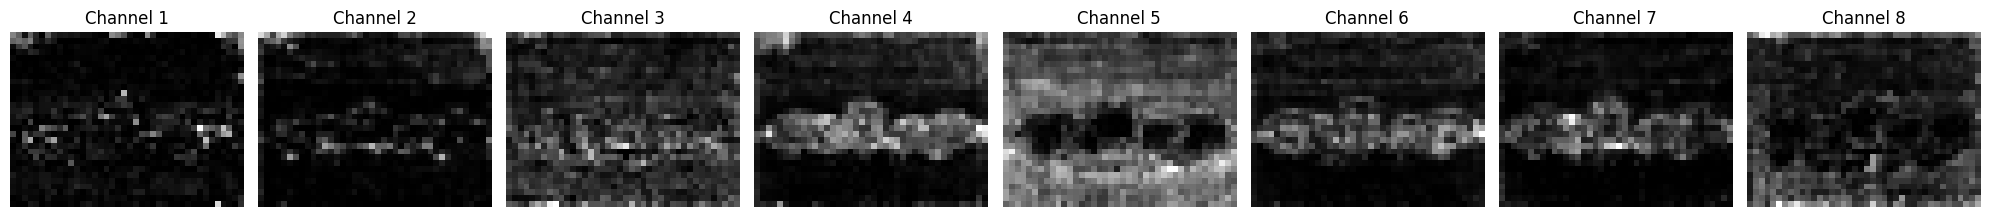

neck_c2f3.m.0.cv1.conv: torch.Size([1, 64, 30, 40])


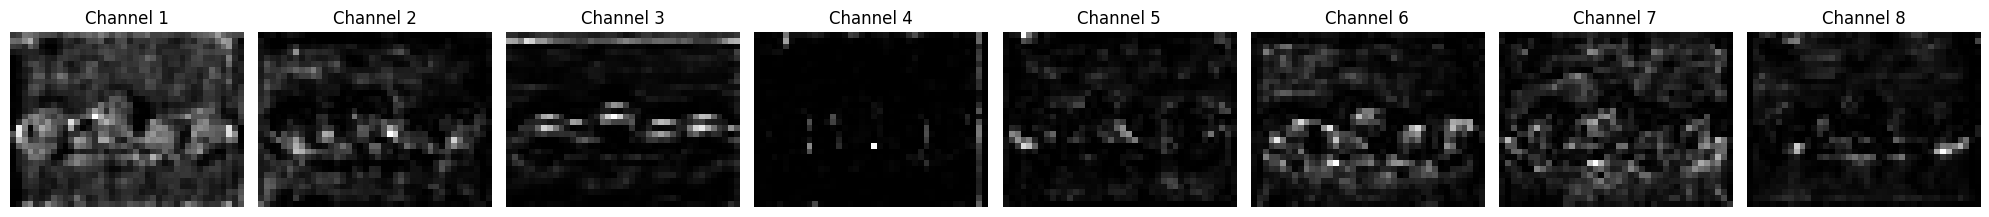

neck_c2f3.m.0.cv2.conv: torch.Size([1, 64, 30, 40])


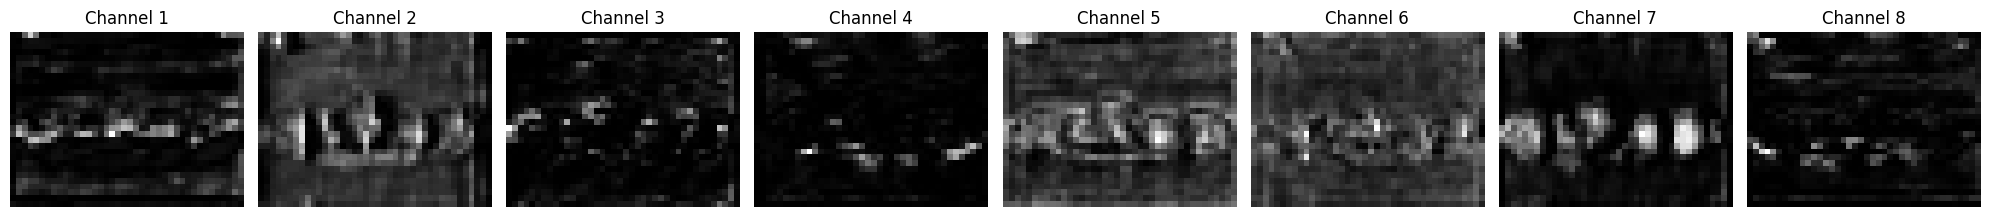

neck_c2f3.cv2.conv: torch.Size([1, 128, 30, 40])


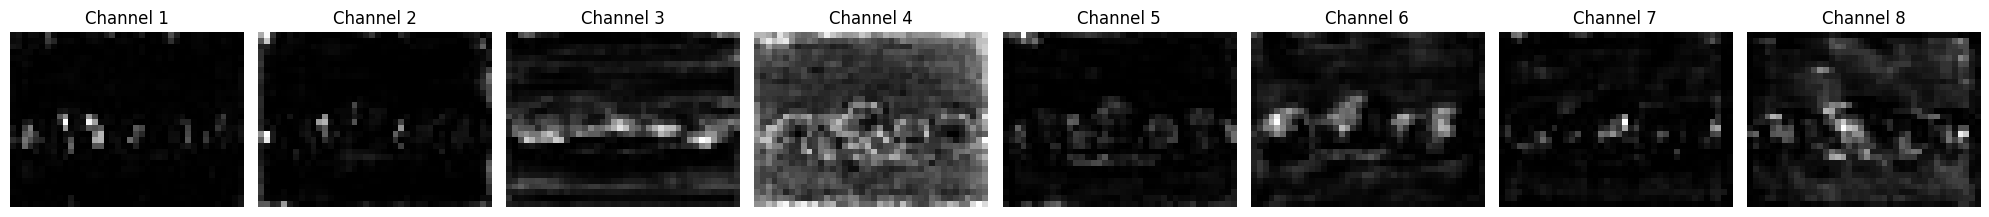

In [16]:
# 加载YOLO模型（以v8为例）
neck_c2f3_nn = yolo_nn[layer_map['neck_c2f3']]
# print(neck_c2f3_nn)
# 存储特征图的字典
features = {}
target_conv = []

features.clear()
# 定义钩子函数：保存当前层输出
def hook_fn(module, input, output, path) -> None:
    features[path] = output

# 遍历c2f中的所有子模块
def register_hooks(module, parent_path="") -> None:
    for name, child in module.named_children():
        current_path = f"{parent_path}.{name}" if parent_path else name
        if isinstance(child, torch.nn.Conv2d):
            child.register_forward_hook(hook=lambda m, i, o, path=current_path: hook_fn(module=m, input=i, output=o, path=path))
        else:
            register_hooks(module=child, parent_path=current_path)

print('layers in module:\'neck_c2f3\'')    
register_hooks(module=neck_c2f3_nn, parent_path="neck_c2f3")

# 归一化每个通道到[0, 255]（灰度图）
def normalize(feature):
    feature = feature - feature.min()
    feature = feature / (feature.max() + 1e-8)
    return (feature * 255).byte().cpu().numpy()
     
# 输入测试数据触发前向传播
output = yolo(source='./images/puppies.jpg')
# 提取特征图（features字典中保存了各卷积层的输出）
print('feature size in each layer')
for path, feature in features.items():
    print(f"{path}: {feature.shape}")
     # 选择batch维度的第一个元素
    feature = feature.squeeze(0)
    # 选择要可视化的通道（示例：前8个通道）
    num_vis = 8  # 可调整为其他数量（如16）
    selected_channels = feature[:num_vis]  # 或按响应值排序后选择

    # 可视化
    fig, axes = plt.subplots(1, num_vis, figsize=(20, 5))
    for i, (ax, channel) in enumerate(zip(axes, selected_channels)):
        # 归一化并转为二维图像
        img = normalize(channel)
        # 显示灰度图（或用cmap='viridis'显示伪彩色）
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Channel {i+1}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()